In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, nsolve
from sympy import cosh, sin , sinh, cos,exp
from scipy.optimize import fsolve
from scipy.integrate import quad

# System constants
e2, $\hbar$ ,amu, Q, parameter P

In [118]:
e2=1.43997 ; hbarc=197.3269718 ; amu=931.4943
z1=82 ; m1=207
z2=2 ; m2=4
Q=7.599
mu=m1*m2/(m1+m2)*amu

# Para's values of pot  
$v_0,a_0,r_0$  
$r_c=r_0$

In [119]:
v0=162.3 ; a0=0.4 ; r0=7.107 ; l=5 ; P=0.3

# Physical model section
$V_N$: cosh           
$V_C$: piecewise    
$V_{pot}$: $V_N+V_C+(l+\frac{1}{2})^2/r^2$  
$k(r)=\sqrt{\frac{2\mu}{\hbar^2}|Q-V(r)|}$  
$F\int_{r_1}^{r_2}dr \frac{1}{k(r)}cos^2[\int_{r_1}^rdr'k(r')-\frac{\pi}{4}]=1$  
F=$1/\int_{r_1}^{r_2}dr \frac{1}{k(r)}cos^2[\int_{r_1}^rdr'k(r')-\frac{\pi}{4}]$
Def wave number k and $\Gamma=PF\frac{\hbar^2}{4\mu}exp[-2\int_{r_2}^{r_3} k(r)dr]$   
$T_{1/2}=\hbar ln2/\Gamma$

In [120]:
def Model(m1,m2,z1,z2,l,Q,v0,a0,r0,P):
    rc=r0
    def wspot(r,v0,a0,r0):
        return -v0*(1+np.cosh(r0/a0))/(np.cosh(r/a0)+np.cosh(r0/a0))

    def vc(r,z1,z2,rc):
        return np.where(
            r < rc,
            z1 * z2 * e2 * (3 - r**2 / rc**2) /(2 * rc),
            z1 * z2 * e2 / r
        )
    
    def vpot(r,v0,a0,r0,z1,z2,rc,l):
        return wspot(r,v0,a0,r0)+vc(r,z1,z2,rc)+(l+0.5)**2/r**2*hbarc**2/(2*mu)

    # guesses = np.linspace(0.1, 80, 100)# Find classical turning points
    # roots = []

    def f(r):
        return vpot(r, v0, a0, r0, z1, z2, rc, l)-Q

    x_values = np.linspace(0.1, 80, 100)
    f_values = f(x_values)
    roots = []

    for i in range(len(f_values) - 1):
        # Check for a sign change
        if np.sign(f_values[i]) != np.sign(f_values[i + 1]):
            # Estimate root using fsolve, starting from the midpoint
            guess = (x_values[i] + x_values[i + 1]) / 2
            root = fsolve(f, guess)[0]
            # Avoid duplicate roots
            if root > 0 and not any(np.isclose(root, r, atol=1e-5) for r in roots):
                roots.append(root)

    roots.sort()        # sort from small roots to large roots
    print("Roots:", roots)

    def k(r):
        return np.sqrt(2*mu/hbarc**2*np.abs(Q-vpot(r,v0,a0,r0,z1,z2,rc,l))) 
    #内部积分函数
    def inner_integral(r):
        result, _ = quad(k, roots[0], r)
        return result
    #被积函数
    def integrand(r):
        inner_int = inner_integral(r)
        return (1 / k(r)) * np.cos(inner_int - np.pi / 4)**2

    integral_result, _ = quad(integrand, roots[0], roots[1])    
    print("Integral result:", integral_result)
    F=1/integral_result
    print("F:", F)


    result,_=quad(k,roots[1],roots[2])
    # print("result:",result)

    gamma=P*F*hbarc**2/(4*mu)*exp(-2*result)
    print("gamma:",gamma,"MeV")

    T_half=hbarc*np.log(2)/gamma
    print("T_half:",T_half,"fm")

    T_half=T_half*1e-23/3
    print('T_half',T_half,'s')

    return T_half

In [121]:
test=Model(m1,m2,z1,z2,l,Q,v0,a0,r0,P)
# print(test)

Roots: [1.156335338305215, 7.780529432806546, 31.74502085919467]
Integral result: 1.1099963941511488
F: 0.9009038274982265
gamma: 2.50887853464069e-21 MeV
T_half: 5.45170410855263e+22 fm
T_half 0.181723470285088 s


# emcee to mcmc the log posterior
log_posterior function:  
y: data  $\to$ lifetime $T_{1/2}$  
sigma: data point uncertainty  
a: para vector

In [122]:
y=np.array([0.516])
sigma=np.array([0.01])

def log_prior(a):
    v,a,r=a

    sigma_v=5
    sigma_a=0.1
    sigma_r=0.5

    prior_v=-0.5*(v-v0)**2/sigma_v**2
    prior_a=-0.5*(a-a0)**2/sigma_a**2
    prior_r=-0.5*(r-r0)**2/sigma_r**2

    return prior_v+prior_a+prior_r

def log_posterior(a,y,sigma,m1,m2,z1,z2,l,Q,P):
    
    prior_value=log_prior(a)   
    f=Model(m1,m2,z1,z2,l,Q,a[0],a[1],a[2],P)

    return -0.5*(y-f)**2/sigma**2

M: number of paras for BA

In [123]:
M=3; R=0.1
nwalkers=8
initial_pos = [v0, a0, r0]
perturbation_scale = [1, 0.01, 0.1]  # 每个参数的扰动大小

a = np.array([initial_pos + np.random.normal(0, perturbation_scale, M) for _ in range(nwalkers)])

print(a)

[[161.43771584   0.38944073   6.97665626]
 [162.29959903   0.41568226   7.19504552]
 [162.17898979   0.39959848   7.06294895]
 [162.56534381   0.39579531   7.02888484]
 [163.57100605   0.40203515   7.00857276]
 [162.70492931   0.39117179   7.19517687]
 [162.8387682    0.40290627   7.13532384]
 [163.2464566    0.40748541   6.9755872 ]]


In [124]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, M, log_posterior, args=[y,sigma,m1,m2,z1,z2,l,Q,P],a=4)
state = sampler.run_mcmc(a, 5)
sampler.reset()
sampler.run_mcmc(state,5)

Roots: [1.1648811104102503, 7.616082770288647, 31.74502085919467]
Integral result: 1.1447279518928404
F: 0.8735700026774671
gamma: 1.16726622780464e-21 MeV
T_half: 1.17176896661225e+23 fm
T_half 0.390589655537417 s
Roots: [1.1535076674750524, 7.90605207145144, 31.74502085919467]
Integral result: 0.951456467781985
F: 1.0510202346211157
gamma: 5.21577748094072e-21 MeV
T_half: 2.62236329389828e+22 fm
T_half 0.0874121097966093 s
Roots: [1.1583656476216206, 7.7312198594950665, 31.74502085919467]
Integral result: 1.1752906930340514
F: 0.8508533300969714
gamma: 1.92016546135088e-21 MeV
T_half: 7.12316916977439e+22 fm
T_half 0.237438972325813 s
Roots: [1.1576461624036252, 7.688242571139352, 31.74502085919467]
Integral result: 1.1863594988639092
F: 0.8429148171002363
gamma: 1.56442021467697e-21 MeV
T_half: 8.74296003518750e+22 fm
T_half 0.291432001172917 s
Roots: [1.153526311353157, 7.680607932018783, 31.74502085919467]
Integral result: 1.1844734412523905
F: 0.8442570049883605
gamma: 1.54634532

C:\Users\16437\AppData\Local\Temp\ipykernel_33836\551915937.py:50: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


Integral result: 1.028167908217409
F: 0.9726037858288679
gamma: 8.61425033864386e-22 MeV
T_half: 1.58779497663327e+23 fm
T_half 0.529264992211091 s
Roots: [1.1407511610504664, 8.055549249069566, 31.74502085919467]
Integral result: 1.041043632937354
F: 0.960574531519349
gamma: 8.25838922122145e-21 MeV
T_half: 1.65621443223007e+22 fm
T_half 0.0552071477410022 s
Roots: [1.1548058692296823, 7.703855093355466, 31.74502085919467]
Integral result: 1.1575850780273238
F: 0.863867389949541
gamma: 1.69174991808830e-21 MeV
T_half: 8.08492039450852e+22 fm
T_half 0.269497346483617 s
Roots: [1.1604668471948802, 7.51407959498695, 31.74502085919467]
Integral result: 0.9763623178797455
F: 1.0242099492036787
gamma: 9.66103039703981e-22 MeV
T_half: 1.41575617227652e+23 fm
T_half 0.471918724092173 s
Roots: [1.1826446169975844, 7.458089763502486, 31.74502085919467]
Integral result: 0.8507796936093488
F: 1.1753924165227767
gamma: 7.40626468651234e-22 MeV
T_half: 1.84676945722299e+23 fm
T_half 0.6155898190743

State([[161.06785749   0.39308245   6.83007886]
 [162.92908309   0.41182247   6.94149138]
 [162.17712838   0.40228447   6.95581564]
 [162.8829874    0.38114064   6.9280385 ]
 [163.61755524   0.40534344   6.8638285 ]
 [162.69531837   0.40217262   7.03714972]
 [162.20868006   0.39222664   6.96195892]
 [164.46292575   0.42580458   6.77990495]], log_prob=[-1.57886953e+01 -1.22553742e+02 -1.02343139e+02 -1.70415214e-01
 -2.32989075e+00 -3.25719303e+02 -6.34220629e+01 -7.78590899e-03], blobs=None, random_state=('MT19937', array([  17266483, 2854521406, 3261221633, 1897735097,  192961660,
       1507497184, 2093256957, 3475088116, 3733788056, 2187178291,
       3287212719, 1399321684, 3528079900, 1452793824, 3736004396,
       2591970360,  509609431, 3635210714,  777709865,  890289952,
       1729261608, 1447621374, 2005444948,  989900655, 1500820069,
       2592998277, 3001499316, 2436205534, 1412042685, 3507639458,
       3224633256, 2102901504, 1005541067,  611268181,  576254873,
        8

# corner to give posterior figures

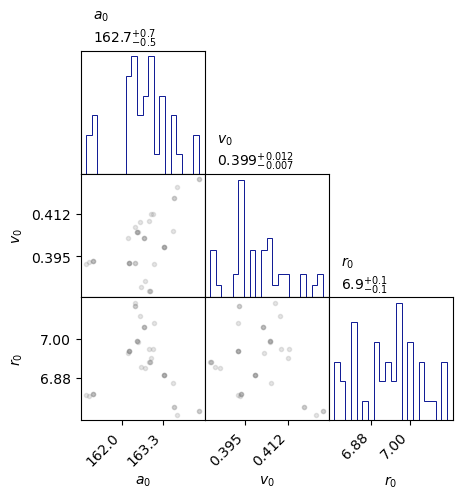

In [128]:
import prettyplease
samples = sampler.get_chain(flat=True)
# plt.hist(samples[:,3], 100, color="k", histtype="step", density=True)
# plt.xlabel(r"$\theta$")
# plt.ylabel(r"$p(\theta|D)$")
# plt.gca().set_yticks([]);
labels = ["$a_0$", "$v_0$", "$r_0$"]
fig = prettyplease.corner(samples,labels=labels)
plt.show()  